
Custom Workloads with Dask Delayed
==================================

<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg" 
     width="30%" 
     align=right
     alt="Dask logo">

*Because not all problems are dataframes*

This notebook shows using [dask.delayed](http://dask.pydata.org/en/latest/delayed.html) to parallelize generic Python code.  

Dask.delayed is a simple and powerful way to parallelize existing code.  It allows users to delay function calls into a task graph with dependencies.  Dask.delayed doesn't provide any fancy parallel algorithms like Dask.dataframe, but it does give the user complete control over what they want to build.

Systems like Dask.dataframe are built with Dask.delayed.  If you have a problem that is paralellizable, but isn't as simple as just a big array or a big dataframe, then dask.delayed may be the right choice for you.

## Start Dask Client for Dashboard

Starting the Dask Client is optional.  It will provide a dashboard which 
is useful to gain insight on the computation.  

The link to the dashboard will become visible when you create the client below.  We recommend having it open on one side of your screen while using your notebook on the other side.  This can take some effort to arrange your windows, but seeing them both at the same is very useful when learning.

In [1]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)
client

Client Scheduler: tcp://127.0.0.1:42851 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 7.29 GB


## Create simple functions

These functions do simple operations like add two numbers together, but they sleep for a random amount of time to simulate real work.

In [2]:
import time
import random

def inc(x):
    time.sleep(random.random())
    return x + 1

def dec(x):
    time.sleep(random.random())
    return x - 1
    
def add(x, y):
    time.sleep(random.random())
    return x + y 

We can run them like normal Python functions below

In [3]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

CPU times: user 26.3 ms, sys: 11.4 ms, total: 37.7 ms
Wall time: 1.71 s


3

These ran one after the other, in sequence.  Note though that the first two lines `inc(1)` and `dec(2)` don't depend on each other, we *could* have called them in parallel had we been clever.

## Annotate functions with Dask Delayed to make them lazy

We can call `dask.delayed` on our funtions to make them lazy.  Rather than compute their results immediately, they record what we want to compute as a task into a graph that we'll run later on parallel hardware.

In [4]:
import dask
inc = dask.delayed(inc)
dec = dask.delayed(dec)
add = dask.delayed(add)

Calling these lazy functions is now almost free.  We're just constructing a graph

In [5]:
x = inc(1)
y = dec(2)
z = add(x, y)
z

Delayed('add-d71bdce8-3e10-48f5-a275-3ed035141abd')

## Visualize computation

You will need graphviz installed for this to work

Unable to revert mtime: /usr/share/fonts/cMap
Unable to revert mtime: /usr/share/fonts/cmap/adobe-cns1
Unable to revert mtime: /usr/share/fonts/cmap/adobe-gb1
Unable to revert mtime: /usr/share/fonts/cmap/adobe-japan1
Unable to revert mtime: /usr/share/fonts/cmap/adobe-japan2
Unable to revert mtime: /usr/share/fonts/cmap/adobe-korea1


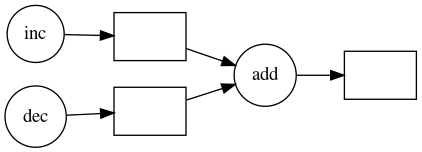

In [6]:
z.visualize(rankdir='LR')

## Run in parallel

Call `.compute()` when you want your result as a normal Python object

If you started `Client()` above then you may want to watch the status page during computation.

In [7]:
z.compute()

3

## Parallelize Normal Python code

Now we use Dask in normal for-loopy Python code.  This generates graphs instead of doing computations directly, but still looks like the code we had before.  Dask is a convenient way to add parallelism to existing workflows.

In [8]:
zs = []

In [9]:
%%time
for i in range(256):
    x = inc(i)
    y = dec(x)
    z = add(x, y)
    zs.append(z)

CPU times: user 26.9 ms, sys: 8.19 ms, total: 35.1 ms
Wall time: 32.8 ms


In [10]:
zs = dask.persist(*zs)  # trigger computation in the background

To make this go faster, add additional workers.

(although we're still only working on our local machine, this is more practical when using an actual cluster)

In [11]:
client.cluster.scale(10)  # ask for ten 4-thread workers

By looking at the Dask dashboard we can see that Dask spreads this work around our cluster, managing load balancing, dependencies, etc..

## Custom computation: Tree summation

As an example of a non-trivial algorithm, consider the classic tree reduction.  We accomplish this with a nested for loop and a bit of normal Python logic.

```
finish           total             single output
    ^          /        \
    |        c1          c2        neighbors merge
    |       /  \        /  \
    |     b1    b2    b3    b4     neighbors merge
    ^    / \   / \   / \   / \
start   a1 a2 a3 a4 a5 a6 a7 a8    many inputs
```

In [12]:
L = zs
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = add(L[i], L[i + 1])  # add neighbors
        new_L.append(lazy)
    L = new_L                       # swap old list for new

dask.compute(L)

([65536],)

If you're watching the [dashboard's status page](../proxy/8787/status) then you may want to note two things:

1.  The red bars are for inter-worker communication.  They happen as different workers need to combine their intermediate values
2.  There is lots of parallelism at the beginning but less towards the end as we reach the top of the tree where there is less work to do.

Alternativley you may want to navigate to the [dashboard's graph page](../proxy/8787/graph) and then run the cell above again.  You will be able to see the task graph evolve during the computation.

## Further Reading

For a more in-depth introdution to delayed and lazy operation in Dask, see the [dask tutorial](https://github.com/dask/dask-tutorial), notebooks 01 and 01x.